## Basics of Neural ODEs or How I Learned the Velocity of a Falling Object

If you recall from your introductory physics class, the velocity of a falling ball at some time with quadratic drag is given by, 

$$ \frac{dv}{dt} = \theta_1 - \theta_2 v^{2} $$

This is simply Newton's law stating that the change in velocity with respect to time is given by the gravitational constant $\theta_1$ (which works to speed up the ball) minus some drag coefficient $\theta_2$ times the square of the velocity (which works to reduce the speed of the ball when it's going fast). 

First, let's implement the forward model.  Below, you will need to code just the right hand side of the equation above.

In [1]:
from scipy.integrate import odeint #This will solve our ODEs
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def dvdt(v, t, thetas): # velocity of the falling baseball from newton #
    ### TODO implement the dynamics function provided above given a list of thetas
    ### Hint: The t argument is just present to make the ode solver happy. It is not actually used in the function.
    return thetas[0] - thetas[1] * v**2

Now that we have a function that describes how $v$ changes through time, we can use the scipy package odeint to perform numerical integration through time and produce an approximate numerical solution.

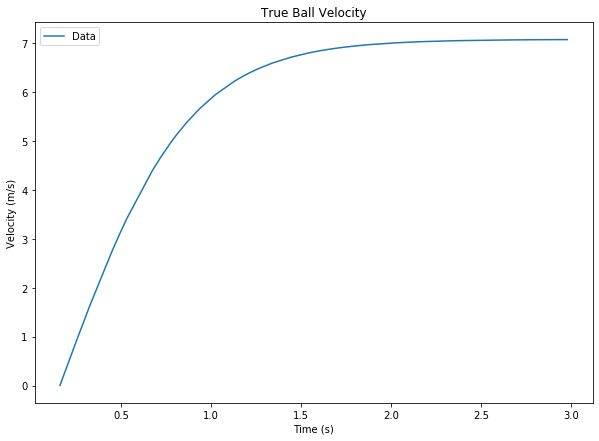

In [2]:
#times = np.linspace(0, 3, 50) # These are the times at which we would like to output our solution 
times = np.sort(np.random.uniform(0., 3, 50)) #added uneven spacing
true_thetas = [10, 0.2] # These are the parameters that we will take to be "true".  Later, we will try to recover them
initial_velocity = 0 #The initial condition of our velocity

out = odeint(dvdt, initial_velocity, times, (true_thetas,)) #Integrate our dynamics function outputting at each time
v_true = out[:,0]

plt.figure(figsize =(10,7))
plt.plot(times, v_true, '-', label = 'Data') #plot the data and the inital guess
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('True Ball Velocity')
plt.legend()

Now let's imagine that we didn't know the true parameters, but wanted to recover them from data.  We can simulate some noisy data as follows:

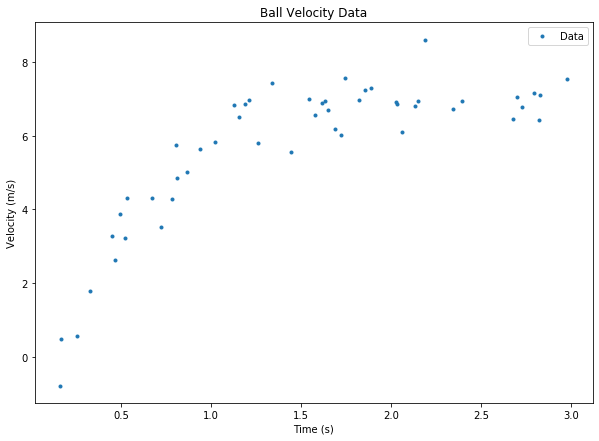

In [3]:
# Add some noise to give us our true 'observations'
v_train = v_true + np.random.randn(v_true.size)*0.5

plt.figure(figsize =(10,7))
plt.plot(times, v_train, '.', label = 'Data') #plot the data and the inital guess
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ball Velocity Data')
plt.legend()

Let's take a wrong guess as to what our parameters might be, and see how well we predict the data:

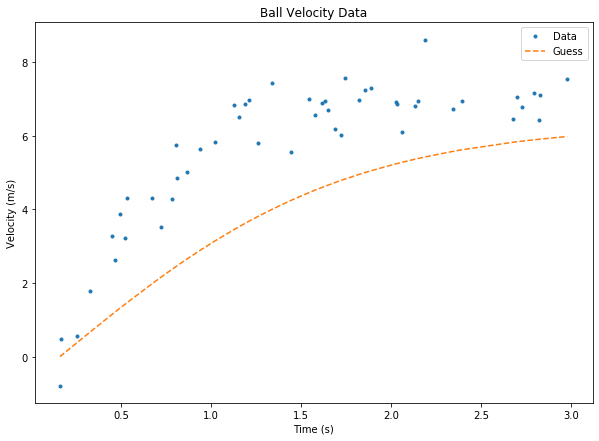

In [4]:
# Now, let's pretend like we don't know the true values of our thetas.
guess_thetas = [4, .1] #Make an inital guess as to what the parameters might be.

### This is for plotting later
meshv = np.linspace(0, 9, 27)
mesht = np.linspace(0, 3, 12)
meshv, mesht = np.meshgrid(meshv,mesht)
changet = np.ones(meshv.shape)*5

out = odeint(dvdt, initial_velocity, times, (guess_thetas,))
v_guess = out[:,0]

plt.figure(figsize =(10,7))
plt.plot(times, v_train, '.', label = 'Data') #plot the data and the inital guess
plt.plot(times, v_guess, '--', label = 'Guess')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Ball Velocity Data')
plt.legend()

Maybe your guess is good, but maybe it's not.  As always in ML, we need to train our parameters by minimizing a loss function.  For our purposes, the loss will be sum squared error:
$$ L = \sum_{t_i \in t_{obs}} \frac{1}{2} \left( v(t_i) - v_{obs,i}\right)^2.$$

We would like to use the adjoint method to compute the gradient of this cost function with respect to the parameters $\theta_0$ and $\theta_1$.  To begin, we will need to derive the continuous analog of the chain rule, namely the adjoint, which gives us $a(t) = \frac{\partial L}{\partial v}$ at any point in time.  Equation 4from Chen provides us with the adjoint equation, which is another ODE that we can solve:
$$ \frac{\partial a}{\partial t} = -a(t) \frac{\partial f(v,t,\theta)}{\partial v}, $$ where $f(v,t,\theta)$ is the right hand side of the ODE.

### Question 1: Show that
$$ \frac{\partial f(v,t,\theta)}{\partial v(t)} = -2 \theta_1 v(t) $$

That is in fact the partial derivative I got in my head.

Note that this equation depends on $v(t)$!  Thus we either have to store $v(t)$ from the forward pass (which is equivalent to reverse mode AD), or we have to solve the equation for $v(t)$ backwards in time along with the adjoint equation, which is what we do here.

If we had a continuous cost function, the adjoint equation would also have a source term.  However, because our observations are discrete, we have a discontinous jump in the value of the adjoint at every observation.  The natural way of handling this discontinuity is to solve the adjoint equation backwards in time over every interval between observations, with initial condition $a(t_i)^+$ given by
$$
a(t_i)^+ = a(t_i)^- + v(t_i) - v_{obs}(t_i),
$$

where $a(t_i)^{-}$ is the adjoint at $t_i$ before we see the observation.  In words, this says that we should solve the adjoint equation backwards in time until we encounter an observation.  When we encounter an observation, we add the residual between the modeled and observed velocity at that point to the adjoint (discontinuously) and then continue solving backwards in time until we get to the next observation, and so on.  This discontinuous treatment can be seen in the adjoint method below.  

With the adjoint in hand, we can compute the gradients of the cost with respect to the parameters $\theta_1$ and $\theta_2$ using Equation 5 from Chen.  If take the derivative of Eq. 5 with respect to time, we get another ODE for each parameter's gradient:
$$
\frac{\partial g_{\theta_k}}{\partial t} = -a(t) \frac{\partial f(v,t,\theta)}{\partial \theta_k},
$$
where $g_{\theta_k} = \frac{\partial L}{\partial \theta_k}$.  These ODEs are easy to solve by appending them to the adjoint.  Thus, for this problem the backward pass involves solving a system of four ODEs simultaneously: the adjoint equation, the forward model (but backwards in time), and an ODE for each parameter. 

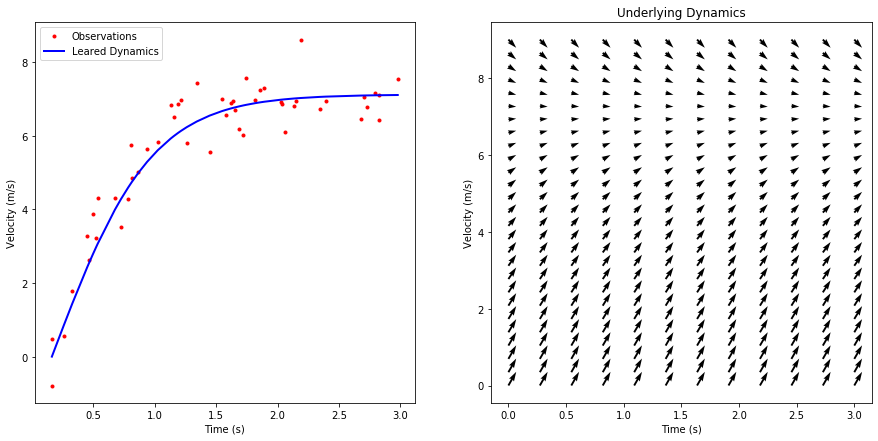

Iter 6400


In [5]:
class FallingVelocity():
    
    def __init__(self, observations, thetas, times):
        
        self.observations = observations #our observation velocity
        self.thetas = thetas  #list of initial params must have opposite signs!
        self.times = times #our observation times
        
        
    def _dvdt(self, v, t): ### velocity of the falling baseball from newton : copied from above
        return self.thetas[0] - self.thetas[1]*v**2
    
    def _dadt(self, augmented_state, t):
        v = augmented_state[0]
        a = augmented_state[1]
        dLdtheta0 = augmented_state[2] #You won't use this
        dLdtheta1 = augmented_state[3] #You won't use this either
        
        return np.array([self.thetas[0] - self.thetas[1]*v**2,     # RHS forward model
                         a*2*self.thetas[1]*v,                                      # RHS adjoint equation
                         -a,                                       # integrand for theta_0
                         a*v**2])                                     # integrand for theta_1

    def forward(self):
        #Forward pass integration to get final velocity
        out = odeint(self._dvdt, 0, self.times)
        v_pred = out[:,0]       
        return v_pred    #all velocities are stored merely for ease of plotting purposes.

    def adjoint(self, output):
        currentvel = output #initial velocity 
        
        time_backwards = self.times[::-1] #since we are integrating backwards in time   
        observations_backward = self.observations[::-1]
        augmented_state = [np.array([currentvel,observations_backward[0]-currentvel,0,0])]
        
        for i in range(len(self.times)-1): #Solve odes between each datapoint
                       
            ## Here is where we integrate backwards through the network
            
            backward_time_range = time_backwards[i:(i+2)]
            
            ###TODO add ajoint for theta1 
            backward = odeint(self._dadt,augmented_state[-1],backward_time_range)[-1].ravel()
            augmented_state.append(np.array([backward[0],
                                             backward[1] + backward[0] - observations_backward[i+1],
                                             backward[2],
                                             backward[3]]))     
            
        return augmented_state[-1][2], augmented_state[-1][3] #??? What are we returning here?
    
model = FallingVelocity(v_train, [4, 1.], times)

eta = 0.0001 # Step size to take/learning rate. Breaks pretty easily, be careful here

for i in range(6500):

    output = model.forward()
    
    grad_theta0, grad_theta1 = model.adjoint(output[-1]) ### Only feed the model the final state for backward pass
    
    ### TODO update thetas
    model.thetas[0] -= grad_theta0*eta
    model.thetas[1] -= grad_theta1*eta
       
    if i % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize = (15, 7))
        plt.subplot(121)
        plt.plot(times, v_train, '.r', label='Observations')
        plt.plot(times, output, 'b', label='Leared Dynamics', linewidth = 2)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        plt.subplot(122)
        changev = dvdt(meshv, mesht, model.thetas)
        plt.quiver(mesht, meshv, changet, changev, width = .005)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Underlying Dynamics')
        plt.show()
        print('Iter {:04d}'.format(i))

### Question 2: What would happen the velocity trajectory if we only had observations of the initial and final state?

The network would not learn any intermediate dynamics, it would merely do it's to match the final output. This means it is unlikely that it would learn the same velocity trajecotry that was learned here. This is akin to a classification problem, where the path taken to the solution is not important, as long as the correct output is produced. 

### Question 3: Run the model again, but alter the observation data times so they are no longer evenly spaced. Does this method still work?

The model still works with unevenly spaced observations. Ths indicates usefulness of a neural odes when working with discontinuous time steps. 

## Let's find the velocity again with a neural network
For this section, we'll use the  `torchdiffeq` package, which was created by the authors of the paper.  You can install it with `pip install torchdiffeq`

Now, we can also ask the question: "what if we didn't know the right hand side of the ODE a priori?" what should we do then?  In the previous example, we explicitly knew the ODE that described the dynamics of the velocity.

$$ \frac{dv}{dt} = \theta_1 + \theta_2 v^{2} $$

If we don't know the ODE that describes the velocity, we can represent it with a neural network!

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint as odeint_nn
from torchdiffeq import odeint_adjoint ## Can use this if we want to use the adjoint method

# NN that will be used to approximate dvdt 
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

    
# Number of time steps to integrate forward
batch_time = 10
# Number of batch samples to use in each gradient descent step
batch_size = 10

# This is how minibatch is imiplemented in the torchdiffeq examples. Interestingly, the model can get good 
# results by only training on 10 data points at a time.
def get_batch(y, t):
    
    true_y = torch.Tensor(y)
    t = torch.Tensor(t)
    
    s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

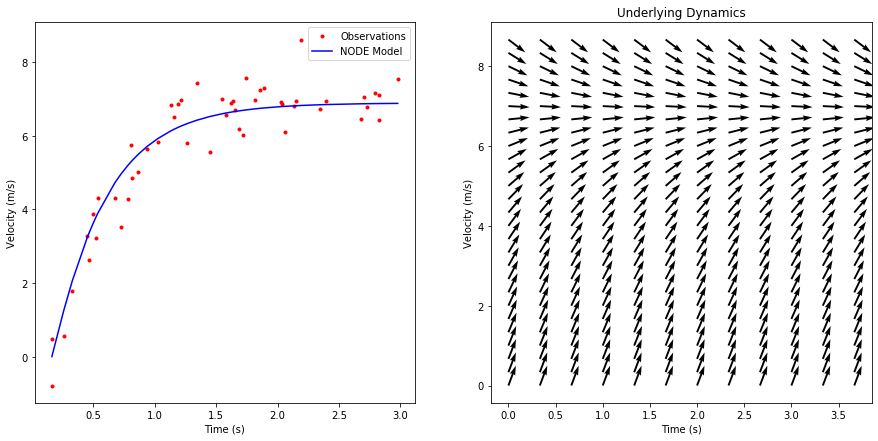

Iter 0900 | Loss 0.462991


In [9]:
vel_train2 = v_train[:,np.newaxis]

model = ODEFunc()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

for itr in range(1000):
    
    optimizer.zero_grad()
    
    # Get initial state, time steps, true y values at each timestep.
    batch_y0, batch_t, batch_y = get_batch(vel_train2, times)

    # TODO: Use NODE to integrate forward
    # Hint: The odeint implemented in the torchdiffeq package uses the same syntax as the scipy odeint function.
    #       Only now, we are using a NN instead of a predefined dvdt function.
    pred_y = odeint_nn(model, batch_y0, batch_t)
    # NOTE: We are just backpropagating throught the ODE solver here. However, if we want to use the 
    #       adjoint method implemented in torchdiffeq, all we have to do is call odeint_adjoint() rather
    #       than odeint_nn(). Both functions use the same syntax.
    
    
    # loss = torch.sqrt(torch.mean((pred_y - batch_y) ** 2))
    loss = torch.mean(torch.abs(pred_y - batch_y))
    
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        clear_output(wait=True)
        with torch.no_grad():
            plt.figure(figsize = (15, 7))
            plt.subplot(121)
            # TODO: Run model forward from time zero at all time steps so we can track progress
            pred_y = odeint_nn(model, torch.tensor([0.]), torch.tensor(times))
            loss = torch.mean(torch.abs(pred_y - torch.Tensor(vel_train2)))
            plt.plot(times, vel_train2, '.r', label='Observations')
            plt.plot(times, pred_y, 'b', label='NODE Model')
            plt.xlabel('Time (s)')
            plt.ylabel('Velocity (m/s)')
            plt.legend()
            plt.subplot(122)
            
            for i in range(4*3):
                for j in range(9*3):
                    changev = model.forward(i/3, torch.tensor([float(j/3)]))
                    plt.quiver(i/3, j/3, 5, changev, width = .005, headwidth = 3)
            plt.xlabel('Time (s)'),
            plt.ylabel('Velocity (m/s)')
            plt.title('Underlying Dynamics')
            plt.show()
            print('Iter {:04d} | Loss {:.6f}'.format(itr, loss.item()))
            

###  Question 4: Try swapping odeint_nn with odeint_adjoint and retraining the model. Is there a change in runtime or number of iterations before convergence? Why do you think we are seeing these differences between the two methods?

The adjoint method has a much longer runtime. The adjoint equation solves several equations backward on the backward pass, meaning more computation must be done on the backward pass than with autodiff. The result is a slower runtime with the adjoint method.   

### Question 5: Why might this example be a bad problem to solve with the adjoint method?

The problem is quite small, making memory cost negligable. So autodiff memory issues will not be a problem, making the more higher computational costs of the adjoint method not necessarily worthwhile. 